#Introduction to Graph Neural Networks with PyTorch

# HOMEWORK 7

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Load the dataset

In [ ]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')


# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


**Define a GCN network**


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


**Visualize the node embeddings of the untrained GCN network using PCA (or t-SNE if you are or want to get familiar with it)**

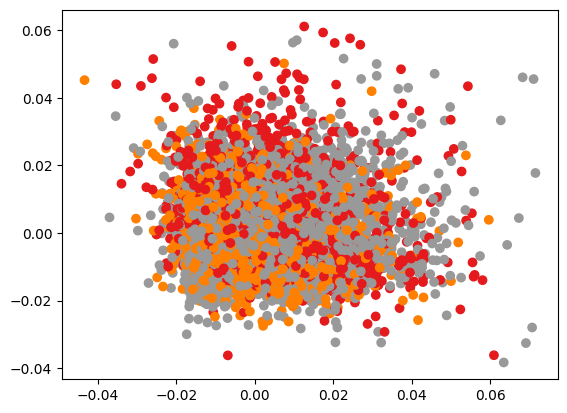

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model.eval()

# Get the node embeddings by passing the node features and the edge index to the model
out = model(data.x, data.edge_index)

# Use PCA to reduce the dimensionality of the node embeddings to 2
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(out.detach().numpy())

# Create a scatter plot of the 2D node embeddings, using the node labels as the color
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=data.y.numpy(), cmap="Set1")
plt.show()

**Perform a grid search hyperparameter tuning for the following parameters:**
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

PS: Remember, first you need to split the data into training, validation and test sets.

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import DataLoader

# Define model with hyperparameters as inputs
class GCN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim, dropout_rate):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.layers.append(GCNConv(dataset.num_features, hidden_dim))
            else:
                self.layers.append(GCNConv(hidden_dim, hidden_dim))
        self.dropout = dropout_rate
        self.out_proj = GCNConv(hidden_dim, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out_proj(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define training function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Define evaluation function
def evaluate(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    return int(correct.sum()) / int(data.test_mask.sum())

#hyperparameters
param_grid = {'num_layers': [2, 3], 'hidden_dim': [16, 32], 'dropout_rate': [0.5, 0.6], 'lr': [0.01, 0.001], 'batch_size': [32, 64]}

# Split data into training, validation, and test sets
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(0.8 * data.num_nodes)] = 1  # 80% of nodes for training
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[int(0.8 * data.num_nodes):int(0.9 * data.num_nodes)] = 1  # 10% for validation
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[int(0.9 * data.num_nodes):] = 1  # 10% for testing

# Perform random search
n_iter_search = 100  # Number of parameter settings that are sampled.
random_search = ParameterSampler(param_grid, n_iter=n_iter_search)

best_val_acc = 0
best_params = None

for params in random_search:
    model = GCN(params['num_layers'], params['hidden_dim'], params['dropout_rate'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=10)  # Add a learning rate scheduler
    for epoch in range(100):
        loss = train(model, data, optimizer)
        val_acc = evaluate(model, data)
        scheduler.step(val_acc)  # Step with validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params

print(f'Best validation accuracy: {best_val_acc}')
print(f'Best parameters: {best_params}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


**Train the GCN model with the optimal hyperparameters**
 - Select the best model based on the highest validation performance (lowest validation loss).*italicized text*
 - Save the best model to load it later for the final evaluation process.

In [ ]:
import torch

model = GCN(best_params['num_layers'], best_params['hidden_dim'], best_params['dropout_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

best_val_loss = float('inf')
best_model = None

for epoch in range(200):
    loss = train(model, data, optimizer)
    val_loss = evaluate(model, data)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print(f'Best validation loss: {best_val_loss}')

# Save the best model
torch.save(best_model.state_dict(), 'best_model.pth')

print("Best model saved with lowest validation loss.")

model = GCN(best_params['num_layers'], best_params['hidden_dim'], best_params['dropout_rate'])
model.load_state_dict(torch.load('best_model.pth'))

print("Best model loaded.")

**Visualize the output embeddings of your trained model. What do you observe?**

In [ ]:
model.eval()

# Get the node embeddings by passing the node features and the edge index to the model
out = model(data.x, data.edge_index)

#PCA to reduce the dimensionality of the node embeddings to 2
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(out.detach().numpy())

#scatter plot of the 2D node embeddings, using the node labels as the color
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=data.y.numpy(), cmap="Set1")
plt.show()

**Evaluate the trained model on the test set and report the classification accuracy**

In [ ]:
# Use the softmax function to get the probabilities
probs = F.softmax(out, dim=1)

# Get the predicted classes
_, preds = probs.max(dim=1)

# Calculate the accuracy on the test set
correct = preds[data.test_mask] == data.y[data.test_mask]
accuracy = int(correct.sum()) / int(data.test_mask.sum())

print(f'Test Accuracy: {accuracy * 100:.2f}%')
